# Improving Customer Segmentation Analysis through Dimmensionality Reduction 
- This case study will improve on the unsupervised learning clustering case study (customer segmentation).
- This case study will demonstrates how Principal Component Analysis (PCA) enhances clustering for customer segmentation while maintaining interpretability and performance.

## Principal Component Analysis (PCA):

PCA is a dimensionality reduction technique that transforms high-dimensional data into a smaller set of components while retaining most of the variance in the data. 
- This is especially useful for clustering, as it can simplify complex datasets and reduce noise, improving clustering performance.

# Load Required Libraries

### We'll begin by retraining the clustering model (KMeans) then we apply PCA and compare performance.

In [45]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessing tools
from sklearn.preprocessing import LabelEncoder  # For encoding categorical variables
from sklearn.preprocessing import StandardScaler  # For standardizing features

# Import dimensionality reduction
from sklearn.decomposition import PCA  # Principal Component Analysis

# Import clustering tools
from sklearn.cluster import KMeans  # K-means clustering algorithm
from sklearn.metrics import silhouette_score  # For evaluating cluster quality

# 1. Data Preparation
### 1.1 Load the Dataset

In [46]:
# Load the customer segmentation dataset from a CSV file into a pandas DataFrame
raw_data = pd.read_csv('customer_segmentation_dataset.csv')

In [47]:
# Display the first 5 rows of the raw_data DataFrame to get a quick overview of its structure and content
raw_data.head()

,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AverageBasketSize,LoyaltyPoints,PreferredCategory,CustomerID,Gender
0,52.704543,60215.004541,71.054078,5.156217,100.408343,1357.513328,Clothing,1117,Female
1,21.918173,49322.316537,70.683512,3.507173,88.413767,659.809063,Luxury,1369,Male
2,34.672262,25647.414471,34.832829,1.270919,27.656651,61.248931,Groceries,423,Male
3,31.112305,30079.037721,37.244059,1.200491,29.166199,165.077975,Groceries,414,Male
4,36.825627,32691.620112,25.714151,1.448637,24.518336,83.783270,Groceries,452,Female


In [48]:
# Display information about the DataFrame 'raw_data'
# This shows the number of rows, columns, column names, non-null values, and data types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1500 non-null   float64
 1   AnnualIncome       1500 non-null   float64
 2   SpendingScore      1500 non-null   float64
 3   PurchaseFrequency  1500 non-null   float64
 4   AverageBasketSize  1500 non-null   float64
 5   LoyaltyPoints      1500 non-null   float64
 6   PreferredCategory  1500 non-null   object 
 7   CustomerID         1500 non-null   int64  
 8   Gender             1500 non-null   object 
dtypes: float64(6), int64(1), object(2)
memory usage: 105.6+ KB


In [49]:
# Generate descriptive statistics for the raw_data DataFrame
# This includes count, mean, std, min, 25%, 50%, 75%, max for numeric columns
raw_data.describe()

,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AverageBasketSize,LoyaltyPoints,CustomerID
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,37.280831,67264.892504,67.323610,6.379343,120.209451,1615.478800,750.500000
std,10.261314,34264.393922,23.568888,4.016314,71.351200,1480.107927,433.157015
min,10.578378,16576.059764,20.013068,1.000061,2.777223,0.298969,1.000000
25%,29.805078,37344.859024,55.056564,2.998994,52.789230,499.107283,375.750000
50%,37.500455,58596.040847,74.839231,5.493192,116.193326,1000.518510,750.500000
75%,44.797507,93588.656419,84.404828,8.504391,169.635239,2249.961077,1125.250000
max,64.073272,150788.808085,99.958682,14.997069,359.655378,4995.641711,1500.000000


#### Create a copy of the data for processing and model training
Keeping the raw data for assessment later.

In [50]:
# Create a copy of the raw_data DataFrame to avoid modifying the original data
# This is a good practice when performing data manipulation operations
data = raw_data.copy()

In [51]:
# Display the first few rows of the dataframe to inspect its structure and content
data.head()

,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AverageBasketSize,LoyaltyPoints,PreferredCategory,CustomerID,Gender
0,52.704543,60215.004541,71.054078,5.156217,100.408343,1357.513328,Clothing,1117,Female
1,21.918173,49322.316537,70.683512,3.507173,88.413767,659.809063,Luxury,1369,Male
2,34.672262,25647.414471,34.832829,1.270919,27.656651,61.248931,Groceries,423,Male
3,31.112305,30079.037721,37.244059,1.200491,29.166199,165.077975,Groceries,414,Male
4,36.825627,32691.620112,25.714151,1.448637,24.518336,83.783270,Groceries,452,Female


### 1.2 Handle Missing Values
Impute missing values using the median for numerical features.

In [52]:
# Check for missing values in the dataset
# This counts the number of null values in each column and returns a Series
data.isnull().sum()

Age                  0
AnnualIncome         0
SpendingScore        0
PurchaseFrequency    0
AverageBasketSize    0
LoyaltyPoints        0
PreferredCategory    0
CustomerID           0
Gender               0
dtype: int64

#### Remove Irrelevant Columns

In [53]:
# Remove CustomerID and LoyaltyPoints columns from the dataframe as they're not needed for analysis
# axis=1 specifies we're dropping columns (not rows)
# inplace=True means the operation modifies the original dataframe instead of returning a copy
data.drop(["CustomerID","LoyaltyPoints"], axis=1, inplace=True)

### 1.3 Encode Categorical Variables
Convert Gender and PreferredCategory into numerical representations.

In [54]:
# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
# Convert 'Gender' from categorical to numerical (e.g., 'Male'/'Female' to 0/1)
data['Gender'] = label_encoder.fit_transform(data['Gender'])
# Convert 'PreferredCategory' from categorical to numerical values
data['PreferredCategory'] = label_encoder.fit_transform(data['PreferredCategory'])

In [55]:
# Display the first few rows of the Transformed dataframe to inspect its structure and content
data.head()

,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AverageBasketSize,PreferredCategory,Gender
0,52.704543,60215.004541,71.054078,5.156217,100.408343,0,0
1,21.918173,49322.316537,70.683512,3.507173,88.413767,3,1
2,34.672262,25647.414471,34.832829,1.270919,27.656651,2,1
3,31.112305,30079.037721,37.244059,1.200491,29.166199,2,1
4,36.825627,32691.620112,25.714151,1.448637,24.518336,2,0


### 1.4 Feature Scaling
Scale numerical features for clustering.

In [56]:
# Define a list of numerical features that need to be standardized or normalized
# These features have different scales and units, so scaling will help improve model performance
features_to_scale = ['Age', 'AnnualIncome', 'SpendingScore', 'PurchaseFrequency', 
                     'AverageBasketSize']

In [57]:
# Apply StandardScaler to normalize numerical features
# This transforms features to have zero mean and unit variance
scaler = StandardScaler()
# Apply the scaling transformation to the selected features in the dataset
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# 2. Clustering
### 2.1 Determine Optimal Number of Clusters
Use the Elbow Method or Silhouette Score to decide the number of clusters.

#### Elbow Method

In [58]:
# Elbow method to determine the optimal number of clusters
inertia = []  # List to store the sum of squared distances of samples to their closest cluster center
K = range(1, 11)  # Testing K values from 1 to 10
for k in K:
    # Initialize KMeans with k clusters and fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the model to the data
    kmeans.fit(data)
    # Append the inertia (sum of squared distances) to our list
    inertia.append(kmeans.inertia_)

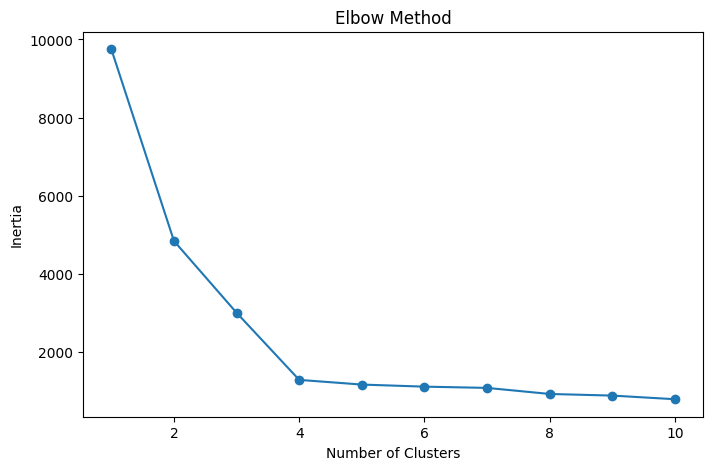

In [59]:
# Plot inertia values for different K values to find optimal number of clusters
plt.figure(figsize=(8, 5))  # Create a new figure with specified size (8x5 inches)
plt.plot(K, inertia, marker='o')  # Plot the inertia values with circle markers
plt.title("Elbow Method")  # Add title to the plot
plt.xlabel("Number of Clusters")  # Label for x-axis
plt.ylabel("Inertia")  # Label for y-axis (inertia = sum of squared distances)
plt.show()  # Display the plot - used to identify the "elbow" point

#### Silhouette Score

In [60]:
# Compute silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 11):  # Test cluster counts from 2 to 10
    # Initialize KMeans with k clusters and fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the model to our data
    kmeans.fit(data)
    # Calculate silhouette score for this clustering and add to our list
    # Higher silhouette scores indicate better-defined clusters
    silhouette_scores.append(silhouette_score(data, kmeans.labels_))

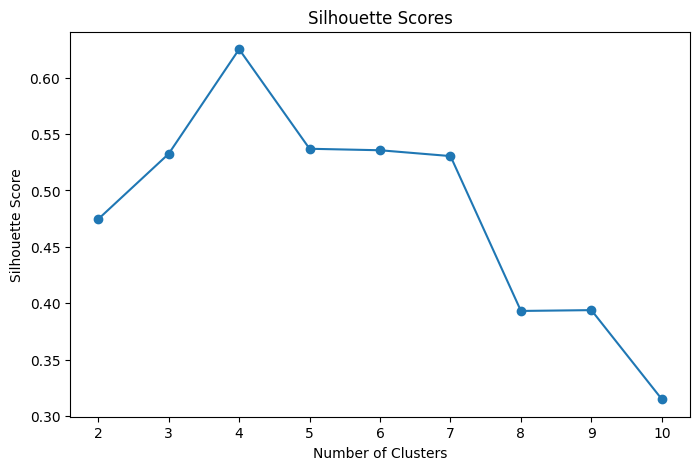

In [61]:
# Plot silhouette scores to visualize clustering quality
plt.figure(figsize=(8, 5))  # Create a figure with specified dimensions (8x5 inches)
plt.plot(range(2, 11), silhouette_scores, marker='o')  # Plot silhouette scores for clusters 2-10 with circle markers
plt.title("Silhouette Scores")  # Add title to the plot
plt.xlabel("Number of Clusters")  # Label for x-axis
plt.ylabel("Silhouette Score")  # Label for y-axis
plt.show()  # Display the plot

### 2.2 Apply K-Means Clustering
The optimal number of clusters is 4 (based on the above analysis).

In [62]:
# Apply K-Means clustering with the optimal number of clusters
optimal_k = 4  # Number of clusters determined from previous analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)  # Initialize K-Means with fixed random seed for reproducibility
kmeans.fit(data)  # Train the K-Means model on our dataset

KMeans(n_clusters=4, random_state=42)

#### We will revert to using the raw data for assessment of the model

In [24]:
raw_data['Cluster'] = kmeans.labels_

In [63]:
# Assign cluster labels from the KMeans model to each data point in the raw_data DataFrame
raw_data['Cluster'] = kmeans.labels_

In [65]:
# Display the first few rows of the raw_data DataFrame to inspect its structure and content of the kmeans labels
raw_data.head()

,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AverageBasketSize,LoyaltyPoints,PreferredCategory,CustomerID,Gender,Cluster
0,52.704543,60215.004541,71.054078,5.156217,100.408343,1357.513328,Clothing,1117,Female,3
1,21.918173,49322.316537,70.683512,3.507173,88.413767,659.809063,Luxury,1369,Male,2
2,34.672262,25647.414471,34.832829,1.270919,27.656651,61.248931,Groceries,423,Male,1
3,31.112305,30079.037721,37.244059,1.200491,29.166199,165.077975,Groceries,414,Male,1
4,36.825627,32691.620112,25.714151,1.448637,24.518336,83.783270,Groceries,452,Female,1


# Now let apply PCA
We will apply PCA to the preprocessed dataset to reduce its dimensionality and compare the clustering results with and without PCA.

In [66]:
# Apply Principal Component Analysis (PCA) to reduce dimensionality
pca = PCA()  # Initialize PCA object with default parameters
pca_data = pca.fit_transform(data)  # Fit PCA to the data and transform it to the new coordinate system

### Determine the Optimal Number of Components
- Select the number of principal components to retain at least 90% of the variance.

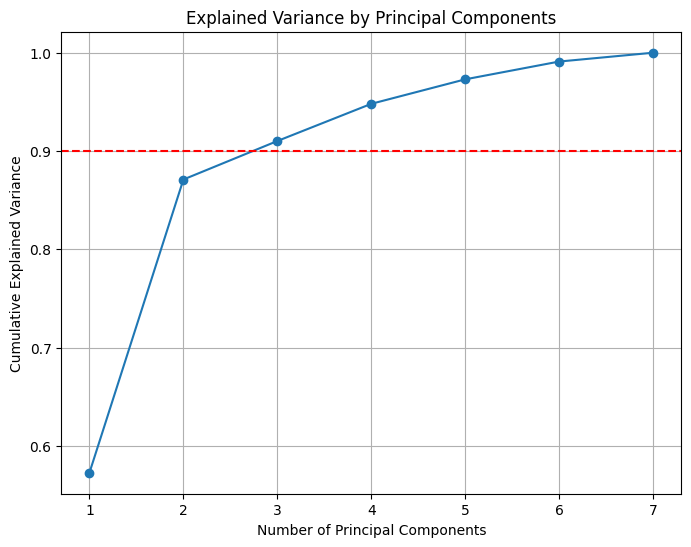

In [67]:
# Plot the cumulative explained variance ratio to determine how many components to keep
explained_variance = pca.explained_variance_ratio_.cumsum()  # Calculate cumulative sum of variance explained
plt.figure(figsize=(8, 6))  # Create figure with specified size
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')  # Plot cumulative variance with markers
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')  # Add horizontal line at 90% threshold
plt.title('Explained Variance by Principal Components')  # Add title to the plot
plt.xlabel('Number of Principal Components')  # Label x-axis
plt.ylabel('Cumulative Explained Variance')  # Label y-axis
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

### Apply PCA with Selected Components
- Reduce the dataset to the chosen number of components.

In [68]:
# Create a PCA (Principal Component Analysis) object that will reduce the dimensionality
# of our data to 3 components. This is useful for visualization and can help reduce
# computational complexity while preserving most of the variance in the data.
pca = PCA(n_components=3)

In [69]:
# Apply PCA transformation to the data
# First fits the PCA model to the data, then transforms the data to the lower-dimensional space
reduced_data = pca.fit_transform(data)

In [70]:
# Print the shape of the reduced data to verify the dimensionality reduction worked correctly
# This helps confirm that the PCA or other reduction method successfully transformed the data
print(f"Reduced data shape: {reduced_data.shape}")

Reduced data shape: (1500, 3)


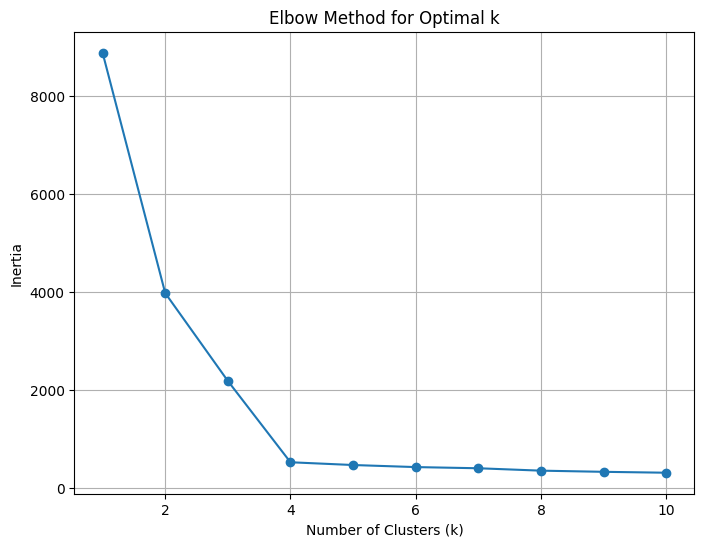

In [71]:
# Elbow method to determine the optimal number of clusters
inertia = []  # List to store the sum of squared distances of samples to their closest cluster center
k_values = range(1, 11)  # Testing cluster values from 1 to 10
for k in k_values:
    # Initialize KMeans with k clusters and a fixed random state for reproducibility
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    # Fit KMeans to the PCA-reduced data
    kmeans_pca.fit(reduced_data)
    # Store the inertia (sum of squared distances to closest cluster center)
    inertia.append(kmeans_pca.inertia_)
    
# Plot the elbow curve to visualize the optimal k value
plt.figure(figsize=(8, 6))  # Create a figure with specified size
plt.plot(k_values, inertia, marker='o')  # Plot k values vs inertia with circle markers
plt.title('Elbow Method for Optimal k')  # Add title to the plot
plt.xlabel('Number of Clusters (k)')  # Label for x-axis
plt.ylabel('Inertia')  # Label for y-axis
plt.grid()  # Add grid lines for better readability
plt.show()  # Display the plot

In [72]:
# Train K-Means with optimal number of clusters
optimal_k = 4  # Setting the optimal number of clusters to 4 based on previous analysis
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)  # Initialize K-Means model with optimal clusters and fixed random state for reproducibility
clusters = kmeans_pca.fit_predict(reduced_data)  # Fit the model to the PCA-reduced data and predict cluster assignments for each data point

In [73]:
# Add cluster labels to the original dataset
# This line assigns the cluster labels (from a clustering algorithm like K-means)
# to a new column called 'Cluster' in the original dataframe 'data'
data['Cluster'] = clusters

### Evaluate and compare model performance with and without PCA

In [74]:
# Calculate the Silhouette Score using the original (non-PCA) dataset
# This evaluates how well the data points fit within their assigned clusters.
silhouette_original = silhouette_score(data, kmeans.labels_)
print(f"Silhouette Score without PCA: {silhouette_original}")

# Calculate the Silhouette Score using the PCA-reduced dataset
# This shows whether dimensionality reduction improved or worsened clustering quality.
silhouette_pca = silhouette_score(reduced_data, kmeans_pca.labels_)
print(f"Silhouette Score with PCA: {silhouette_pca}")


Silhouette Score without PCA: 0.6715120366378521
Silhouette Score with PCA: 0.751319631958127


### Performance Metrics
Silhouette Score (Higher scores indicate better-defined clusters):

- Measures how similar points are within their cluster compared to other clusters. This indicates that PCA not only reduced dimensions but also improved cluster separation.

### Reduce to 2 components for visualization
PCA reduces dimensions, making visualizations (e.g., 2D scatter plots) easier to interpret.

In [75]:
# Create a new PCA model that reduces the data to 2 components
# This is useful for visualizing the clusters in a 2D plot.
pca_2d = PCA(n_components=2)

# Apply the 2-component PCA transformation to the already reduced data
# 'reduced_data' is likely the output of a previous PCA (e.g., 3 components).
# The result, 'reduced_data_2d', can be plotted on an x-y plane.
reduced_data_2d = pca_2d.fit_transform(reduced_data)


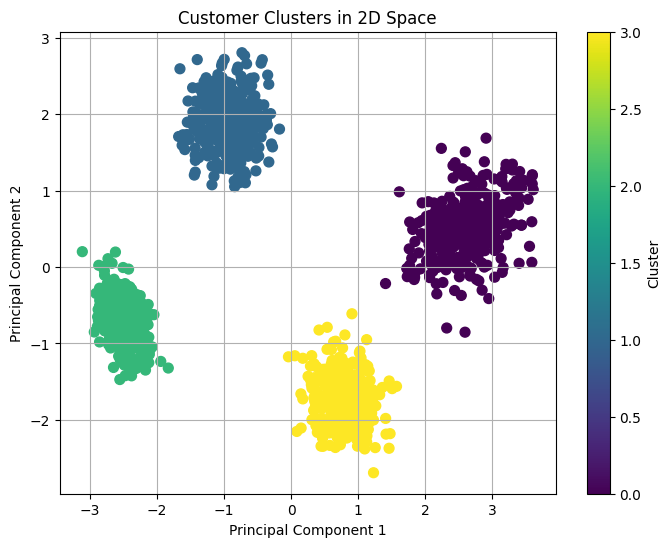

In [76]:
# Scatter plot of clusters
# Create a figure for the 2D visualization of PCA-transformed customer clusters
plt.figure(figsize=(8, 6))

# Scatter plot using the 2D PCA components
# 'c=clusters' colors each point by its assigned cluster
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=clusters, cmap='viridis', s=50)

# Add a descriptive title and axis labels
plt.title('Customer Clusters in 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add color bar to show which color corresponds to which cluster
plt.colorbar(label='Cluster')

# Add grid lines for easier reading of the plot
plt.grid()

# Display the plot
plt.show()


# Insights from PCA
### 4.1. Key Insights
**Dimensionality Reduction:**

- PCA reduced the dataset to 3 dimensions, capturing a significant percentage of variance (~90%).
- This simplified the clustering process without losing much information.

**Improved Visualization:**

- The PCA-reduced dataset allowed for an intuitive 2D scatter plot of the clusters, making them easier to interpret.

**Clustering Performance:**

- The silhouette score for PCA-reduced data is better than the original data, demonstrating PCAs ability to improve clustering performance while reducing dimensionality.


### 4.2 Dimensionality Reduction Benefits:

- PCA simplified the dataset while preserving its structure, improving both interpretability and computational efficiency.
- Reduced noise and redundant features may lead to more distinct clusters.
- With PCA: Simplifies visualization, may improve performance metrics.
- Without PCA: Retains full feature information, but clustering performance may be affected by noise or irrelevant dimensions.

Actionable Use:
- Use PCA for datasets with many features to improve computational efficiency and visualization.
- Evaluate both silhouette scores and explained variance to ensure reduced dimensions are meaningful.